## ROMY ARRAY DATA

### Importing

In [1]:

import os, subprocess
import numpy as np
import matplotlib.pyplot as plt 
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees
from andbro__querrySeismoData import __querrySeismoData
from tqdm import tqdm
from obspy.core.util import AttribDict
# from pydsm.relab import shiftdim


#from andbro__save_to import __save_to
#from andbro__get_data import __get_data


### Initializing Settings

In [14]:
plt.style.use('default') # print(plt.style.available)   

%matplotlib inline

### Setting Variables

In [17]:

#ipath = '/home/brotzer/'
#ifile = ''

#opath = '/home/brotzer/'
#ofile = ''

config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2019-05-14T12:17:00.000")
config['tend'] = obspy.UTCDateTime("2019-05-14T14:00:10.000")


config['client'] = RoutingClient("eida-routing")

### Defining Methods

In [18]:

def __plotArrayGeometryAndResponse(array, transff, klim, kstep, unit=None):
    
    ## calulcate geometrical center of array
    array_center = [np.median(array[:,0]), np.median(array[:,1])]
    
    ## find geometrical limits of array
    lon_min, lon_max = np.min(array[:,0]), np.max(array[:,0])
    lat_min, lat_max = np.min(array[:,1]), np.max(array[:,1])
    
    ## define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim
    
    
    ## _________________________________________________________
    ##
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12
    
    if unit is "km":
        xdata = (array[:,0]-array_center[0])*111.
        ydata = (array[:,1]-array_center[1])*111. * np.cos(array[:,1]/180.*np.pi)
        x0, y0 = 0.0, 0.0
    elif unit is "deg":
        xdata = array[:,0]
        ydata = array[:,1]
        x0, y0 = array_center[0], array_center[1]
        
    ## ________________________________________________
    axes[0].plot(xdata, ydata,'kv')
    axes[0].scatter(x0, y0, color='red', marker='o', s=15)
    
    if unit is "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
                 
    elif unit is "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)
                 
    axes[0].set_title('Square Array configuration', fontsize=fs+2)

    
    ## ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
               np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
               transff.T, cmap=obspy_sequential)
    
    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)
    
    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('ARF Square Array', fontsize=fs+2)
    
    plt.show()    


In [19]:

def __getArrayStations(seed_id, tbeg, tend, fur_coords):

    net, sta, loc, cha  = seed_id.split(".")

    route =  RoutingClient("eida-routing")
    inv_check =route.get_stations(
                            network=net, 
                            station=sta,
                            channel=cha,
                            starttime=tbeg,
                            endtime=tend,
                            latitude=fur_coords[0],
                            longitude=fur_coords[1],
                            minradius=0,
                            maxradius=0.1,
                            )
    
    
    inv_check.plot(projection="local");
    
    
    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(inv_check):
        for i, station in enumerate(network):
             
            codes.append(f'{inv_check[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)
            
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev':elev})
    
    return frame


In [20]:

def __calculateDistanceOfStations(array_stations):
    '''
    from obspy.geodetics import locations2degrees

    '''
    
    N = len(array_stations)
    
    dist_in_deg = np.zeros((N, N))

    for i, station1 in array_stations.iterrows():
        for j, station2 in array_stations.iterrows():
            dist_in_deg[i][j] = locations2degrees(lat1  = station1[2], 
                                                  long1 = station1[1], 
                                                  lat2  = station2[2], 
                                                  long2 = station2[1],
                                                  )
            
    return dist_in_deg, np.max(dist_in_deg)*111.0


In [21]:

def __plotArraySection(st_in, scal, comp=None): 
    
    if comp is not None:
        st_in = st_in.select(component = comp);
        title = f'{comp}-components of ROMY Array'
        
    names = [tr.stats.station for tr in st_in]
    
    fs = 14
    
    ## _________________________________________
    ##
    fig, ax = plt.subplots(1,1, figsize=(13,6))
    
    if len(st_in) > 50: 
        print(f"only 50 of {len(st_in)} traces are plotted!")
        st_in = st_in[:30]
        
    for istation in range(len(st_in)):
        tmp = st_in[istation].data
        
        if len(tmp) == 0:
            print('no data for station:', st_in[istation].stats.station)
        
        else:
            if scal > 0:
                tmp1 = tmp/(np.max(tmp)-np.min(tmp))
            else:
                tmp1 = tmp
            
            timeline = np.arange(0,len(tmp1),1)*st_in[istation].stats.delta
            
            ax.plot(timeline, tmp1*np.abs(scal)+istation*np.abs(scal),'k')
    
    ax.set_yticks(np.arange(0,len(st_in), 1)*scal)
    ax.set_yticklabels(names, fontsize = fs)    
#     ax.set_yticklabels(np.arange(0,len(st_in),1)+1)
    ax.set_xlabel(f'Time from {st_in[0].stats.starttime.date} {st_in[0].stats.starttime.time} UTC (s)', fontsize = fs, labelpad=10)
    ax.set_title(title, fontsize = fs)
    
    plt.show();
    return fig


In [22]:

def __getStream(array_stations, tbeg, tend):
    
    '''
    from obspy.core.util import AttribDict

    '''
    
    ## request waveforms
    st = obspy.Stream(traces=None)
    for i, station in array_stations.iterrows():
        print(f"requesting {station[0]}..BH* ...")

        try:
            st0, st_inv = __querrySeismoData(f"{station[0]}..BH*", tbeg, tend, restitute = True, details=None)
            
        
        except:
            print(f'--> failed for {station[0]}!')
        


        st += st0
    
    
    ## check for doubles
    codes = []; removed = 0
    for tr in st:
        code = f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}"
        if code in codes:
            st.remove(tr)
            removed += 1
        else:
            codes.append(code)
    
    st.merge(); 
    print(f'\n{removed} doubles have been removed!')
    
    return st


In [23]:

def __TimeShift(st, timematrix): 
    
    '''
    timemaxtrix have same length as station
    
    '''
    
    ## create copy to not overwrite the stream
    st_shift=st.copy()
    
    
    ##all waveforms resampled to the same sampling rate
    maximal_frequency = 1/st[0].stats.delta 
    
    Nfft = st[0].stats.npts 
    
    central_frequencies  = maximal_frequency/2*np.linspace(0,1,endpoint=True, num=np.int(Nfft/2+1)); 
    
    
    for i in range(len(st)):
        
        delay = timematrix[i] ##compute lag from slownesses 
        rep   = np.exp(1j*2*np.pi*central_frequencies*delay)
        vehlp = np.fft.fft(st_shift[i].data)
        shft  = shiftdim(vehlp[0:len(central_frequencies)],1,nargout=1)
        dshft = rep.T*shft
        s_sh  = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
        
        st_shift[i].data=s_sh
    
    
    return st_shift


In [8]:

# def __calulcateBeamPower(st, sl_min, sl_max, sl_step):
    
#     '''
#     from pydsm.relab import shiftdim

#     '''


#     def shiftdim(array, n=None):

#     from collections import deque
#     import numpy as np        

#     if n is not None:
#         if n >= 0:
#             axes = tuple(range(len(array.shape)))
#             new_axes = deque(axes)
#             new_axes.rotate(n)
#             return np.moveaxis(array, axes, tuple(new_axes))
#         return np.expand_dims(array, axis=tuple(range(-n)))
#     else:
#         idx = 0
#         for dim in array.shape:
#             if dim == 1:
#                 idx += 1
#             else:
#                 break
#         axes = tuple(range(idx))
#         # Note that this returns a tuple of 2 results
#         return np.squeeze(array, axis=axes), len(axes)

    
#     ## define slowness grid extensions
#     Eslowness = np.arange(sl_min, sl_max+sl_step, sl_step)
#     Nslowness = np.arange(sl_min, sl_max+sl_step, sl_step)
    
#     N_slow = len(Eslowness)
    
#     ## get distancens to center of array
#     array_coords = np.zeros((len(st), 2))
#     for i, tr in enumerate(st): 
#         array_coords[i][0] = tr.stats.coordinates.latitude
#         array_coords[i][1] = tr.stats.coordinates.latitude
    
#     distN = (array_coords[:,0] - np.median(array_coords[:,0]))*111.0; 
#     distE = (array_coords[:,1] - np.median(array_coords[:,1]))*111.0 * np.cos(np.median(array_coords[:,1])/180*np.pi);

    
#     ## relevant parameters for frequency domain
#     dt   = st[0].stats.delta  ## sampling interval
#     Fmax = np.int(1/dt); ## maximum frequency
#     Nfft = st[0].stats.npts ## number of sample in each chopped seismogram (i.e. number in fft)
#     frq  = Fmax/2*np.linspace(0,1,endpoint=True, num=np.int(Nfft/2+1)); ## central frequencies

#     beam = np.zeros([N_slow, N_slow])

#     for ind1 in range(N_slow):

#         for ind2 in range(N_slow):

#             stdel = np.zeros([len(st)])

#             for ind3 in np.arange(len(st)):

#                 delay = -1*(distN[ind3]*Nslowness[ind1] + distE[ind3]*Eslowness[ind2]) ##compute lag from slownesses 
                
#                 rep   = np.exp(1j*2*np.pi*frq*delay)
                
#                 vehlp = np.fft.fft(st[ind3].data)
                
#                 shft  = shiftdim(vehlp[0:len(frq)],1,nargout=1)
                
#                 dshft = rep.T*shft
                
#                 s_sh  = np.double(2*np.real(np.fft.ifft(dshft, Nfft)))
                
#                 stdel = stdel + s_sh/np.max(np.abs(s_sh))

#             beam[ind1,ind2] = np.sum((stdel/len(inp))**2)


#     ## determine peak
#     indextuple = np.unravel_index(np.argmax(beam, axis=None), beam.shape)

#     beampeak = beam[indextuple]

#     beampeak_y = NsloV[indextuple[0]]
#     beampeak_x = EsloV[indextuple[1]]

#     ## calculate back azimuth
#     baz = np.rad2deg(np.arctan2(beampeak_x,beampeak_y))
    
#     print('Slowness [s/km]: %g'%(np.sqrt(beampeak_x**2+beampeak_x**2) ))
#     print(f'Back azimuth from North [degree]: {baz}')

#     return beam, beampeak_x, beampeak_y, baz

# __calulcateBeamPower(st, sl_min=-0.3, sl_max=0.3, sl_step=0.03)

### Obtain Station Information

In [24]:
## get station info of FUR

net, sta, loc, cha  = "GR.FUR..BHZ".split(".")
 
inv = c.get_stations(network = net, 
                    station = sta,
                    channel = cha,
                    starttime = tbeg,
                    endtime = tend
                    ) 


fur_coords = [inv[0][0].latitude, inv[0][0].longitude, inv[0][0].elevation]


In [25]:
## get all stations around ROMY

array_stations = __getArrayStations("*.*..B*Z", tbeg, tend, fur_coords)

array_stations

FileNotFoundError: [Errno 2] No such file or directory: '/home/YOUR_USER/anaconda3/share/proj/epsg'

### Calulcate Distances, Plot Array Geometry and Response

In [11]:

dist, dist_max = __calculateDistanceOfStations(array_stations)


lambda_min = .5*dist_max # in km

k_max = 2*np.pi/lambda_min
k_step = k_max / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

## compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates, 
                                   k_max, 
                                   k_step, 
                                   coordsys='lonlat'
                                  )

    
__plotArrayGeometryAndResponse(coordinates, transff, k_max, k_step, unit="deg")

NameError: name 'array_stations' is not defined

### Obtain Waveforms

requesting BW.FFB1..BH* ...

Get data:  BW.FFB1..BH* (3.0) ...

Using Eida-Routing...

Requesting from 1 network(s) and 1 station(s)

pre-filter is applied: (0.01, 0.05, 20, 40)

removing response ...

output VEL

Finished
_______________

requesting BW.FFB2..BH* ...

Get data:  BW.FFB2..BH* (3.0) ...

Using Eida-Routing...

Requesting from 1 network(s) and 1 station(s)
--> failed for BW.FFB2!
requesting BW.FFB3..BH* ...

Get data:  BW.FFB3..BH* (3.0) ...

Using Eida-Routing...

Requesting from 1 network(s) and 1 station(s)

pre-filter is applied: (0.01, 0.05, 20, 40)

removing response ...

output VEL

Finished
_______________

requesting BW.TON..BH* ...

Get data:  BW.TON..BH* (3.0) ...

Using Eida-Routing...

Requesting from 1 network(s) and 1 station(s)

pre-filter is applied: (0.01, 0.05, 20, 40)

removing response ...

output VEL

Finished
_______________

requesting BW.GELB..BH* ...

Get data:  BW.GELB..BH* (3.0) ...

Using Eida-Routing...

Requesting from 0 network(s) and 0 sta

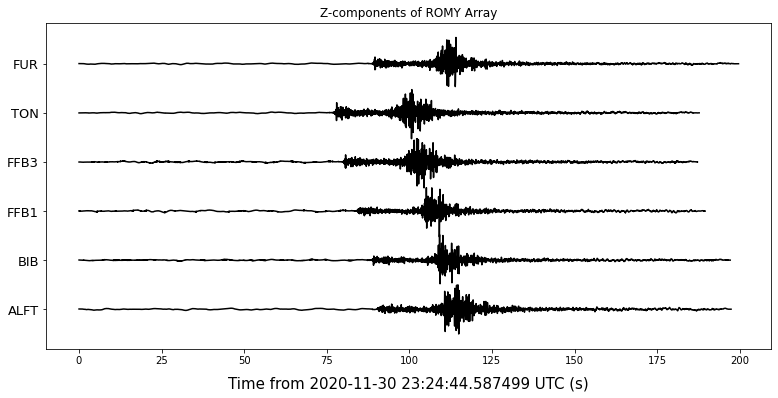

In [171]:
tstart = obspy.UTCDateTime('2020-11-30 23:25:00')
tdelta = 3 # in minutes


stream = __getStream(array_stations, tstart, tstart+tdelta*60)

## plot traces for checkup
__plotArraySection(stream, scal=1, comp='Z');

### Process Waveforms

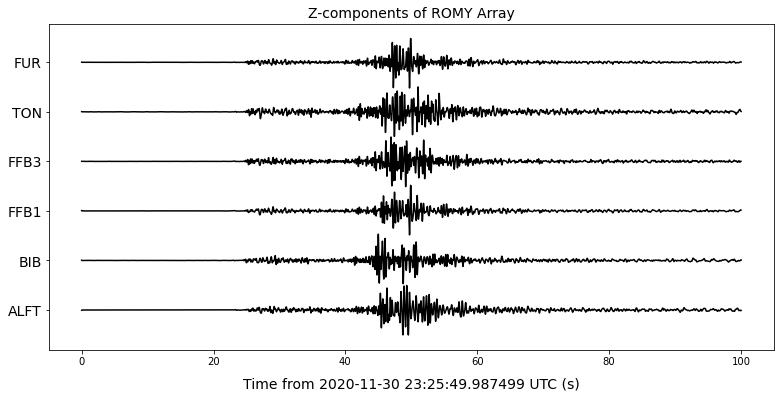

In [177]:
resampling_rate = 40.
freq_max = 5
freq_min = 0.5

t1 = tstart + 50
t2 = tstart + 150

## ____________________________________
## detrend, bandpass filtering, resampling, trimming

st = stream.copy()

st.detrend('demean')
st.detrend()

st.filter('bandpass', 
          freqmin=freq_min, 
          freqmax=freq_max, 
          corners=4, 
          zerophase=True
         )

st.trim(starttime = t1, 
        endtime = t2, 
#         pad = True, 
#         fill_value = 0
       )

st.resample(resampling_rate)

## plot traces for checkup
__plotArraySection(st, scal=1, comp='Z');

### Beamforming / F-K Analysis

In [180]:
from obspy.signal.array_analysis import array_processing
from matplotlib.colorbar import ColorbarBase
from obspy.imaging.cm import obspy_sequential
from matplotlib.colors import Normalize


def __plotSlownessAndBackazimuth(out):
    cmap = obspy_sequential

    # make output human readable, adjust backazimuth to values between 0 and 360
    t, rel_power, abs_power, baz, slow = out.T
    baz[baz < 0.0] += 360

    # choose number of fractions in plot (desirably 360 degree/N is an integer!)
    N = 36
    N2 = 30
    abins = np.arange(N + 1) * 360. / N
    sbins = np.linspace(0, 3, N2 + 1)

    # sum rel power in bins given by abins and sbins
    hist, baz_edges, sl_edges =  np.histogram2d(baz, slow, bins=[abins, sbins], weights=rel_power)

    # transform to radian
    baz_edges = np.radians(baz_edges)

    # add polar and colorbar axes
    fig = plt.figure(figsize=(8, 8))
    cax = fig.add_axes([0.85, 0.2, 0.05, 0.5])
    ax = fig.add_axes([0.10, 0.1, 0.70, 0.7], polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    dh = abs(sl_edges[1] - sl_edges[0])
    dw = abs(baz_edges[1] - baz_edges[0])

    # circle through backazimuth
    for i, row in enumerate(hist):
        bars = ax.bar((i * dw) * np.ones(N2),
                      height = dh * np.ones(N2),
                      width = dw, bottom=dh * np.arange(N2),
                      color = cmap(row / hist.max())
                     )

    ax.set_xticks(np.linspace(0, 2 * np.pi, 4, endpoint=False))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])

    # set slowness limits
    ax.set_ylim(0, 3)
    [i.set_color('grey') for i in ax.get_yticklabels()]
    ColorbarBase(cax, 
                 cmap=cmap,
                 norm=Normalize(vmin=hist.min(), vmax=hist.max())
                )

    plt.show()

## perfom a f-k analysis 
out = array_processing(st, 
                       win_len = 3., 
                       win_frac = 0.25, 
                       sll_x = -3.0, 
                       slm_x = 3.0, 
                       sll_y = -3.0, 
                       slm_y = 3.0, 
                       sl_s = 0.03, 
                       semb_thres = -1e9,
                       vel_thres = -1e9, 
                       frqlow = 0.5, 
                       frqhigh = 5., 
                       stime = t1+1, 
                       etime = t2-1, 
                       prewhiten = 0,  
                       coordsys='lonlat', 
                       timestamp='mlabday', 
                       method = 0, 
                      )

## get quantities from output
t, rel_power, abs_power, baz, slow = out.T


## get slowness and back azimuth
baz_max = baz[np.argmax(abs_power)]
slow_max = slow[np.argmax(abs_power)]

print(f'slowness: {round(slow_max, 2)} s/km')
print(f'back azimuth: {round(baz_max, 2)} degrees')


## Plot result of F-K Analysis
__plotSlownessAndBackazimuth(out)   

AttributeError: coordinates

In [185]:
stream[3].stats.coordinates

AttribDict({'latitude': 48.1522, 'elevation': 599.0, 'longitude': 11.2473})

In [86]:
__TimeShift(st, timematrix)

NameError: name '__TimeShift' is not defined